You’ll also want to create a dictionary that maps a label id to a label class which will be useful when you set up the model later. Download the mappings from the Hub and create the id2label and label2id dictionaries:


In [32]:
from PIL import Image
import os

def load_image(image_path):
    return Image.open(image_path).convert('RGB')


def load_names_from_csv_convert_to_rgb(folder, max_num=None):
    import os
    import csv

    images = []
    masks = []
    path = f'training_images/{folder}'

    if os.path.exists(path) == False:
        print(f'Path: {path} does not exist')
        return
    
    # get mate_data.csv:
    counter = 0
    with open(f'{path}/meta_data.csv', newline='') as csvfile:
        csv_file = csv.reader(csvfile)
        for row in csv_file:
            counter += 1
            # first row is header
            if counter == 1:
                continue
            image_path = f'{path}/images/{row[0]}'
            image = load_image(image_path)
            images.append(image)

            mask_path = f'{path}/masks/{row[1]}'
            mask = load_image(mask_path)
            masks.append(mask)

            if max_num is not None and counter >= max_num:
                break
    
    return images, masks

def load_names_from_csv_get_paths(folder, max_num=None):
    import os
    import csv

    image_paths = []
    mask_paths = []
    path = f'training_images/{folder}'

    if os.path.exists(path) == False:
        print(f'Path: {path} does not exist')
        return
    
    # get mate_data.csv:
    counter = 0
    with open(f'{path}/meta_data.csv', newline='') as csvfile:
        csv_file = csv.reader(csvfile)
        for row in csv_file:
            counter += 1
            # first row is header
            if counter == 1:
                continue
            image_path = f'{path}/images/{row[0]}'
            image_paths.append(image_path)

            mask_path = f'{path}/masks/{row[1]}'
            mask_paths.append(mask_path)

            if max_num is not None and counter >= max_num:
                break
    
    return image_paths, mask_paths

def create_dataset_from_ready_images(images, labels):
    from datasets import Dataset
    dataset = Dataset.from_dict({"image": images,
                                "label": labels})
    return dataset

def create_dataset(image_paths, label_paths):
    from datasets import Dataset, Image

    dataset = Dataset.from_dict({"image": sorted(image_paths),
                                "label": sorted(label_paths)})
    dataset = dataset.cast_column("image", Image())
    dataset = dataset.cast_column("label", Image())
    return dataset

def create_dataset_dict(traing_dataset, validation_dataset):
    from datasets import DatasetDict
    return DatasetDict({'train': traing_dataset, 'validation': validation_dataset})

In [33]:
forest_images_paths, forest_labels_paths = load_names_from_csv_convert_to_rgb('forest', max_num=100) # remove max_num for real training
forest_dataset = create_dataset_from_ready_images(forest_images_paths, forest_labels_paths)

# tutaj splitowanie danych jest spierdolone, bo niszczy dane!
forest_dataset_split = forest_dataset.train_test_split(test_size=0.2)
forest_train = forest_dataset_split['train']
forest_test = forest_dataset_split['test']



In [34]:
forest_train[0]
forest_train[0].keys()

dict_keys(['image', 'label'])

In [35]:
import json
# create class id to label mapping
id2label = {0: 'forest', 1: 'building', 2: 'car', 3: 'lake', 4: 'meadow', 5: 'person', 6: 'road'}
with open('id2label.json', 'w') as fp:
    json.dump(id2label, fp)
    
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)


Pre-process the data:

In [36]:
from transformers import AutoImageProcessor

checkpoint = "nvidia/mit-b0"
image_processor = AutoImageProcessor.from_pretrained(checkpoint, reduce_labels=True)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
/Users/mac/Coding/inżynieria uczenia maszynowego/lib/python3.12/site-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [37]:
from torchvision.transforms import ColorJitter

jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

In [38]:
def train_transforms(example_batch):
    images = [jitter(img.convert('RGB')) for img in example_batch["image"]]
    labels = [label for label in example_batch['label']]
    example_batch['label'] = image_processor(images, labels,  do_resize=False, return_tensors="pt")
    return example_batch


def test_transforms(example_batch):
    images = [img.convert('RGB') for img in example_batch["image"]]
    labels = [label for label in example_batch['label']]
    example_batch['label'] = image_processor(images, labels, return_tensors="pt")
    return example_batch

before: Dataset({
    features: ['image', 'label'],
    num_rows: 79
})
after: Dataset({
    features: ['image', 'label'],
    num_rows: 79
})


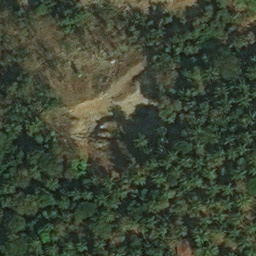

In [39]:
# cos tutaj z transformacjami jest nie tak!!! Powodowało błąd e nie moe zczytać jakiegoś kanału koloru
print(f'before: {forest_train}')
# forest_train.set_transform(train_transforms)
# forest_test.set_transform(test_transforms)

print(f'after: {forest_train}')
forest_train[0]['image']

In [40]:
import evaluate

metric = evaluate.load("mean_iou")

Evaluate:


In [41]:
import numpy as np
import torch
from torch import nn

def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False,
        )
        for key, value in metrics.items():
            if isinstance(value, np.ndarray):
                metrics[key] = value.tolist()
        return metrics

Train:

In [42]:
from transformers import AutoModelForSemanticSegmentation, TrainingArguments, Trainer

model = AutoModelForSemanticSegmentation.from_pretrained(checkpoint, id2label=id2label, label2id=label2id)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
training_args = TrainingArguments(
    output_dir="forest_output",
    learning_rate=6e-5,
    num_train_epochs=50,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    remove_unused_columns=False,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=forest_train,
    eval_dataset=forest_test,
    compute_metrics=compute_metrics,
)

trainer.train()

  0%|          | 0/2000 [00:00<?, ?it/s]

TypeError: must be real number, not PngImageFile

After training we can see the results: